<a href="https://colab.research.google.com/github/zuzka05/stat_learn/blob/main/QuantTradingAccelerator_Part8_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quant Trading Accelerator 🚀

Learn from 0, extremely fast => JIT Learning => Build, Test, Learn, Iterate 🚀

Feedback is important!

## Part 8: Strategy

array => vector => time series => matrices => multi-variate time series => model => regression => classification => cross validation => strategy

In [1]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

Goals:

1. Build a strategy based on our classification model.



In [2]:
#What types of startegy are you running?
#market or limit order?

### Key Decisions

1. Decide what our entry and exit signals are
2. Decide what the trade sizing should be
3. Decide how much leverage to use

In [3]:
#Leverage proportional to stat edge we have

#MM: In some exchanges you get rebates for posting trades
#On a 2-3min level you can't run taking due to fees

### Types of Strategies

*  **Making** => Adding Liquidity
* **Taking** => Taking Liquidity



In [4]:
# numerical computing library for fast calculation
import numpy as np
# data analysis library
import pandas as pd
# data visualization library
import seaborn as sns

# machine learning library
import torch
import torch.nn as nn
import torch.optim as optim

In [81]:
import binance

### Load Data

In [5]:
url = 'https://drive.google.com/uc?export=download&id=1qnX9GpiL5Ii1FEnHTIAzWnxNejWnilKp'
btcusdt = pd.read_csv(url, parse_dates=["open_time"], index_col='open_time')

btcusdt

,open,high,low,close,volume
open_time,,,,,
2020-11-27 00:00:00,17155.37,17418.93,17024.20,17400.00,15427.474
2020-11-27 01:00:00,17401.51,17465.00,17271.30,17309.94,16632.689
2020-11-27 02:00:00,17309.93,17328.09,17072.80,17102.38,16168.837
2020-11-27 03:00:00,17102.10,17277.86,17029.32,17084.05,13670.593
2020-11-27 04:00:00,17084.05,17194.00,17061.00,17079.56,10866.299
...,...,...,...,...,...
2025-11-10 19:00:00,105435.90,106000.00,105354.00,105767.20,2971.178
2025-11-10 20:00:00,105767.10,106249.60,105750.30,105956.70,3483.547
2025-11-10 21:00:00,105956.70,105973.90,105202.70,105583.50,3305.325


### Add Log Returns

In [6]:
#Always look at price movements

In [7]:
btcusdt['close_log_return'] = np.log(btcusdt['close']/btcusdt['close'].shift())
btcusdt

,open,high,low,close,volume,close_log_return
open_time,,,,,,
2020-11-27 00:00:00,17155.37,17418.93,17024.20,17400.00,15427.474,NaN
2020-11-27 01:00:00,17401.51,17465.00,17271.30,17309.94,16632.689,-0.005189
2020-11-27 02:00:00,17309.93,17328.09,17072.80,17102.38,16168.837,-0.012063
2020-11-27 03:00:00,17102.10,17277.86,17029.32,17084.05,13670.593,-0.001072
2020-11-27 04:00:00,17084.05,17194.00,17061.00,17079.56,10866.299,-0.000263
...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.90,106000.00,105354.00,105767.20,2971.178,0.003138
2025-11-10 20:00:00,105767.10,106249.60,105750.30,105956.70,3483.547,0.001790
2025-11-10 21:00:00,105956.70,105973.90,105202.70,105583.50,3305.325,-0.003528


In [8]:
#We're building ARs
#close_log_return - our target

In [9]:
btcusdt['close_log_return_lag_1'] = btcusdt['close_log_return'].shift()
btcusdt['close_log_return_lag_2'] = btcusdt['close_log_return'].shift(2)
btcusdt['close_log_return_lag_3'] = btcusdt['close_log_return'].shift(3)
btcusdt = btcusdt.dropna()
btcusdt[['close_log_return','close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']]

,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
open_time,,,,
2020-11-27 04:00:00,-0.000263,-0.001072,-0.012063,-0.005189
2020-11-27 05:00:00,0.010946,-0.000263,-0.001072,-0.012063
2020-11-27 06:00:00,0.001109,0.010946,-0.000263,-0.001072
2020-11-27 07:00:00,-0.010552,0.001109,0.010946,-0.000263
2020-11-27 08:00:00,-0.014575,-0.010552,0.001109,0.010946
...,...,...,...,...
2025-11-10 19:00:00,0.003138,-0.004455,0.006797,0.001525
2025-11-10 20:00:00,0.001790,0.003138,-0.004455,0.006797
2025-11-10 21:00:00,-0.003528,0.001790,0.003138,-0.004455


### Create Binary Classification Target

*   1 => Long => Price moves up
*   0 => Short => Price moves down

In [10]:
btcusdt['close_log_return_dir'] = btcusdt['close_log_return'].map(lambda x: 1 if x > 0 else 0)

/tmp/ipython-input-408896205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcusdt['close_log_return_dir'] = btcusdt['close_log_return'].map(lambda x: 1 if x > 0 else 0)


In [11]:
#For classification it's very important to look at the distribution of the target

In [12]:
btcusdt[['close_log_return','close_log_return_dir']]

,close_log_return,close_log_return_dir
open_time,,
2020-11-27 04:00:00,-0.000263,0
2020-11-27 05:00:00,0.010946,1
2020-11-27 06:00:00,0.001109,1
2020-11-27 07:00:00,-0.010552,0
2020-11-27 08:00:00,-0.014575,0
...,...,...
2025-11-10 19:00:00,0.003138,1
2025-11-10 20:00:00,0.001790,1
2025-11-10 21:00:00,-0.003528,0


### Check Directional Balance

In [13]:
btcusdt['close_log_return_dir'].value_counts()

,count
close_log_return_dir,
1,22021
0,21415


### Split Data into Train/Test

In [14]:
# time:  t0 ---- t1 ---- t2 ---- t3 ---- t4 ---- t5 ---- t6 ---- t7
# train: [===============================]
# test:                                  [=========================]

In [15]:
def time_split(x, train_size = 0.75):
  i = int(len(x) * train_size)
  return x[:i].copy(), x[i:].copy()

btcusdt_train, btcusdt_test = time_split(btcusdt, train_size = 0.7)

In [16]:
btcusdt_train

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,
2020-11-27 04:00:00,17084.05,17194.00,17061.00,17079.56,10866.299,-0.000263,-0.001072,-0.012063,-0.005189,0
2020-11-27 05:00:00,17079.55,17350.00,17078.78,17267.54,13783.564,0.010946,-0.000263,-0.001072,-0.012063,1
2020-11-27 06:00:00,17267.54,17316.32,17177.00,17286.70,9598.037,0.001109,0.010946,-0.000263,-0.001072,1
2020-11-27 07:00:00,17286.70,17297.90,17040.00,17105.25,13115.712,-0.010552,0.001109,0.010946,-0.000263,0
2020-11-27 08:00:00,17106.79,17116.04,16714.92,16857.75,31574.365,-0.014575,-0.010552,0.001109,0.010946,0
...,...,...,...,...,...,...,...,...,...,...
2024-05-16 20:00:00,65152.30,65270.10,65018.70,65248.00,3804.218,0.001469,0.000934,0.001765,-0.002423,1
2024-05-16 21:00:00,65247.90,65480.00,65204.20,65429.10,4205.893,0.002772,0.001469,0.000934,0.001765,1
2024-05-16 22:00:00,65429.00,65457.00,65100.00,65389.20,4533.237,-0.000610,0.002772,0.001469,0.000934,0


In [17]:
btcusdt_test

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,
2024-05-17 01:00:00,65477.9,65478.0,65061.2,65311.0,6160.987,-0.002554,0.003983,-0.002626,-0.000610,0
2024-05-17 02:00:00,65311.1,65430.0,65146.5,65351.5,4190.566,0.000620,-0.002554,0.003983,-0.002626,1
2024-05-17 03:00:00,65351.4,65850.0,65300.3,65545.2,11900.518,0.002960,0.000620,-0.002554,0.003983,1
2024-05-17 04:00:00,65545.1,65600.0,65327.7,65422.7,5906.313,-0.001871,0.002960,0.000620,-0.002554,0
2024-05-17 05:00:00,65422.8,65675.0,65400.0,65674.9,4946.005,0.003848,-0.001871,0.002960,0.000620,1
...,...,...,...,...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.9,106000.0,105354.0,105767.2,2971.178,0.003138,-0.004455,0.006797,0.001525,1
2025-11-10 20:00:00,105767.1,106249.6,105750.3,105956.7,3483.547,0.001790,0.003138,-0.004455,0.006797,1
2025-11-10 21:00:00,105956.7,105973.9,105202.7,105583.5,3305.325,-0.003528,0.001790,0.003138,-0.004455,0


### Check Classification Balance - Post Split

In [18]:
#Make sure classification target is balanced too

In [19]:
btcusdt_test['close_log_return_dir'].value_counts()

,count
close_log_return_dir,
1,6575
0,6456


In [20]:
btcusdt_train['close_log_return_dir'].value_counts()

,count
close_log_return_dir,
1,15446
0,14959


### Train Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# 0. REPRODUCIBILITY SETTINGS
# -------------------------------------------------------
SEED = 99
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------------------------------------
# 1. STANDARDIZE FEATURES AND CREATE TENSORS
# -------------------------------------------------------

features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
target = 'close_log_return_dir'

# Fit scaler on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(btcusdt_train[features].values)
X_test_scaled  = scaler.transform(btcusdt_test[features].values)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test  = torch.tensor(X_test_scaled,  dtype=torch.float32)

y_train = torch.tensor(btcusdt_train[target].values, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(btcusdt_test[target].values, dtype=torch.float32).unsqueeze(1)

# -------------------------------------------------------
# 2. DEFINE MODEL (Logistic Regression)
# -------------------------------------------------------

no_features = len(features)

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(no_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# -------------------------------------------------------
# 3. TRAINING LOOP (FULL-BATCH GRADIENT DESCENT)
# -------------------------------------------------------
for epoch in range(15000):
    optimizer.zero_grad()
    y_pred_logits = model(X_train)
    loss = criterion(y_pred_logits, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())

# -------------------------------------------------------
# 4. CHECK TRAINED PARAMETERS
# -------------------------------------------------------
print("\nFinal weight:", model.linear.weight.data)
print("Final bias:", model.linear.bias.data)

# -------------------------------------------------------
# 5. EVALUATION ON TEST SET
# -------------------------------------------------------
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_proba = torch.sigmoid(y_pred_logits)
    y_pred_binary = (y_pred_proba >= 0.5).float()

y_test_np = y_test.squeeze().numpy()
y_pred_binary_np = y_pred_binary.squeeze().numpy()
y_pred_proba_np = y_pred_proba.squeeze().numpy()

# Metrics
accuracy = np.mean(y_pred_binary_np == y_test_np)
buy_signals = np.sum(y_pred_binary_np == 1)

print("\n--- Model Evaluation ---")
print(f"Total Test Samples (T): {len(X_test)}")
print(f"Number of Buy Signals (Predicted UP): {int(buy_signals)}")
print(f"Directional Accuracy (DA): {accuracy:.4f}")

# Optional: confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, y_pred_binary_np)
print("\nConfusion Matrix:\n", cm)


Epoch: 0 Loss: 0.806926965713501
Epoch: 500 Loss: 0.7886935472488403
Epoch: 1000 Loss: 0.772722065448761
Epoch: 1500 Loss: 0.7588532567024231
Epoch: 2000 Loss: 0.7469183802604675
Epoch: 2500 Loss: 0.736742377281189
Epoch: 3000 Loss: 0.7281467914581299
Epoch: 3500 Loss: 0.7209532260894775
Epoch: 4000 Loss: 0.7149870991706848
Epoch: 4500 Loss: 0.7100816965103149
Epoch: 5000 Loss: 0.7060809135437012
Epoch: 5500 Loss: 0.7028420567512512
Epoch: 6000 Loss: 0.7002375721931458
Epoch: 6500 Loss: 0.6981555223464966
Epoch: 7000 Loss: 0.6964994072914124
Epoch: 7500 Loss: 0.6951876282691956
Epoch: 8000 Loss: 0.694152295589447
Epoch: 8500 Loss: 0.6933372616767883
Epoch: 9000 Loss: 0.6926972270011902
Epoch: 9500 Loss: 0.6921952962875366
Epoch: 10000 Loss: 0.6918020844459534
Epoch: 10500 Loss: 0.6914945244789124
Epoch: 11000 Loss: 0.6912540793418884
Epoch: 11500 Loss: 0.6910660266876221
Epoch: 12000 Loss: 0.6909191012382507
Epoch: 12500 Loss: 0.6908043026924133
Epoch: 13000 Loss: 0.6907145977020264
Ep

In [22]:
#With ML model, you minimize the loss

### Evaluate Model's Profitability (Out-of-sample)

In [23]:
#Plug the predictions back into df due to splitting the data

In [24]:
btcusdt_test['y_pred_binary'] = y_pred_binary_np
btcusdt_test['y_pred_proba'] = y_pred_proba_np

In [25]:
btcusdt_test[['close_log_return','y_pred_binary','y_pred_proba']]

,close_log_return,y_pred_binary,y_pred_proba
open_time,,,
2024-05-17 01:00:00,-0.002554,1.0,0.500302
2024-05-17 02:00:00,0.000620,1.0,0.518477
2024-05-17 03:00:00,0.002960,1.0,0.508978
2024-05-17 04:00:00,-0.001871,1.0,0.500734
2024-05-17 05:00:00,0.003848,1.0,0.513161
...,...,...,...
2025-11-10 19:00:00,0.003138,1.0,0.515478
2025-11-10 20:00:00,0.001790,0.0,0.497862
2025-11-10 21:00:00,-0.003528,1.0,0.503283


### Encode Directional Signal

In [26]:
#That allows us to calculate trade log return

In [27]:
btcusdt_test['dir_signal'] = np.where(btcusdt_test['y_pred_binary'] == 1, 1, -1)

In [28]:
btcusdt_test[['close_log_return','dir_signal','y_pred_binary','y_pred_proba']]

,close_log_return,dir_signal,y_pred_binary,y_pred_proba
open_time,,,,
2024-05-17 01:00:00,-0.002554,1,1.0,0.500302
2024-05-17 02:00:00,0.000620,1,1.0,0.518477
2024-05-17 03:00:00,0.002960,1,1.0,0.508978
2024-05-17 04:00:00,-0.001871,1,1.0,0.500734
2024-05-17 05:00:00,0.003848,1,1.0,0.513161
...,...,...,...,...
2025-11-10 19:00:00,0.003138,1,1.0,0.515478
2025-11-10 20:00:00,0.001790,-1,0.0,0.497862
2025-11-10 21:00:00,-0.003528,1,1.0,0.503283


### Evaluate Prediction Balance (Directional Distribution)

In [29]:
btcusdt_test['dir_signal'].value_counts()

,count
dir_signal,
1,9924
-1,3107


### Evaluate Trade Log Returns

In [30]:
btcusdt_test['trade_log_return'] = btcusdt_test['dir_signal'] * btcusdt_test['close_log_return']

<Axes: xlabel='open_time'>

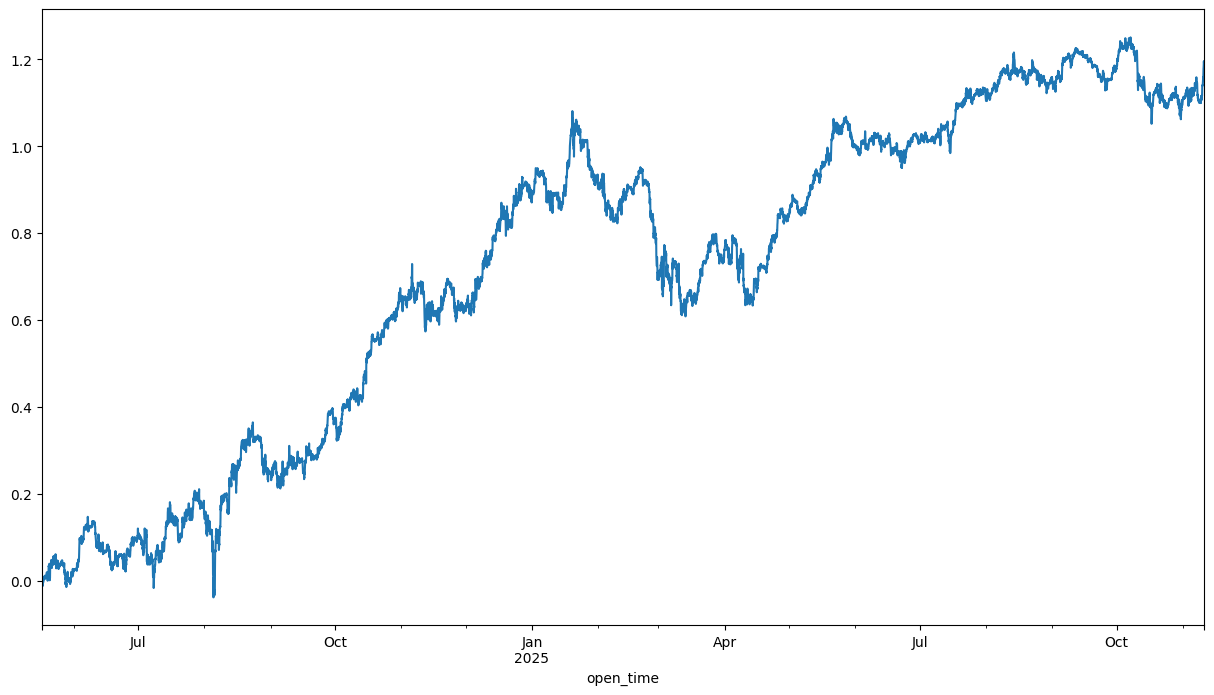

In [31]:
btcusdt_test['trade_log_return'].cumsum().plot(figsize=(15,8))

In [32]:
#For HFT small edge but so many trades that they accumulate

<Axes: xlabel='open_time'>

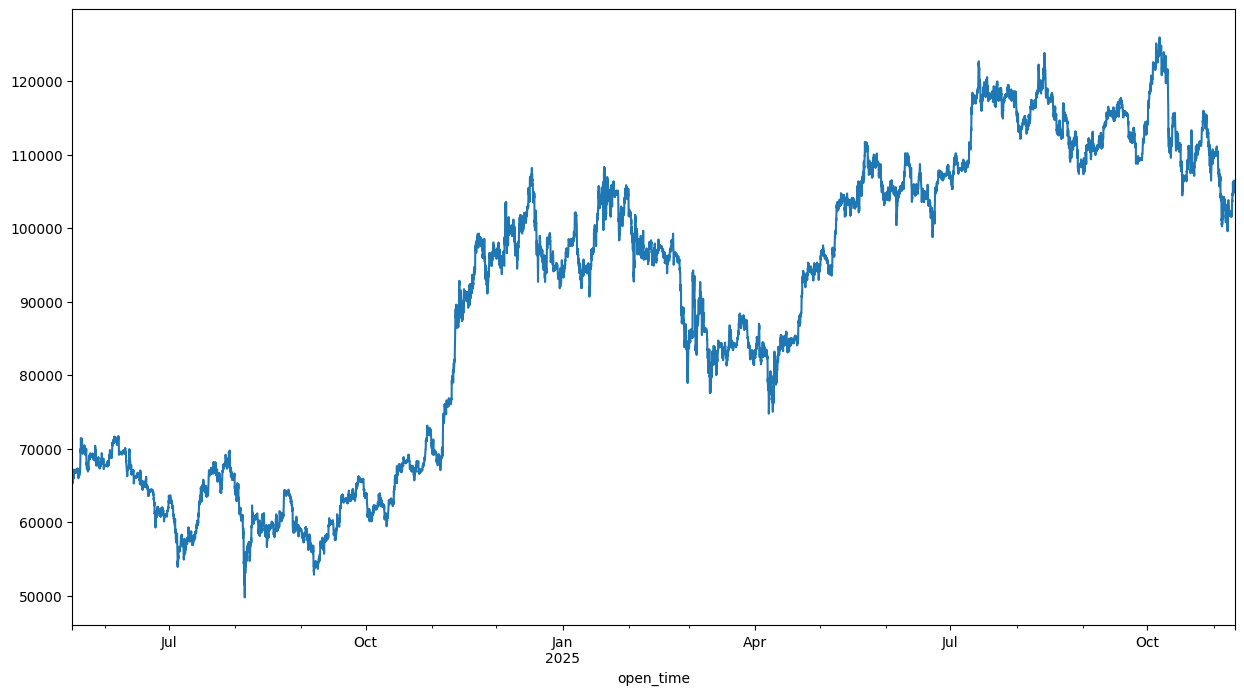

In [33]:
btcusdt_test['close'].plot(figsize=(15,8))

### Strategy

### Entry / Exit Signals

1. Time-Based
2. Predicate-Based

### Time-Based

In [34]:
#Our times series is based on time
#What's the price movement in next 1 hour?
#Our entry signal is 1 hour
#Just before the end of the window we close the position

In [35]:
btcusdt_test

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir,y_pred_binary,y_pred_proba,dir_signal,trade_log_return
open_time,,,,,,,,,,,,,,
2024-05-17 01:00:00,65477.9,65478.0,65061.2,65311.0,6160.987,-0.002554,0.003983,-0.002626,-0.000610,0,1.0,0.500302,1,-0.002554
2024-05-17 02:00:00,65311.1,65430.0,65146.5,65351.5,4190.566,0.000620,-0.002554,0.003983,-0.002626,1,1.0,0.518477,1,0.000620
2024-05-17 03:00:00,65351.4,65850.0,65300.3,65545.2,11900.518,0.002960,0.000620,-0.002554,0.003983,1,1.0,0.508978,1,0.002960
2024-05-17 04:00:00,65545.1,65600.0,65327.7,65422.7,5906.313,-0.001871,0.002960,0.000620,-0.002554,0,1.0,0.500734,1,-0.001871
2024-05-17 05:00:00,65422.8,65675.0,65400.0,65674.9,4946.005,0.003848,-0.001871,0.002960,0.000620,1,1.0,0.513161,1,0.003848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.9,106000.0,105354.0,105767.2,2971.178,0.003138,-0.004455,0.006797,0.001525,1,1.0,0.515478,1,0.003138
2025-11-10 20:00:00,105767.1,106249.6,105750.3,105956.7,3483.547,0.001790,0.003138,-0.004455,0.006797,1,0.0,0.497862,-1,-0.001790
2025-11-10 21:00:00,105956.7,105973.9,105202.7,105583.5,3305.325,-0.003528,0.001790,0.003138,-0.004455,0,1.0,0.503283,1,-0.003528


### Predicate Based

Let's say trade when only there's >= 60% or <= 40% probability

In [36]:
#When stock deviates certain amount from MA
#Below then buy, above SD deviation that's a sell
#It doesn't make enough trades
#It's better to trade more with a smaller edge - professional
#10 trades based on a predicate

In [37]:
#Less than 40% is a short, more than 60% going up

In [38]:
mask = (btcusdt_test['y_pred_proba'] >= 0.55) | (btcusdt_test['y_pred_proba'] <= 0.45)
btcusdt_test[mask]

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir,y_pred_binary,y_pred_proba,dir_signal,trade_log_return
open_time,,,,,,,,,,,,,,
2024-05-19 20:00:00,66002.9,66279.3,65971.0,66134.0,4179.462,0.001984,-0.008518,-0.001894,0.000807,1,1.0,0.552632,1,0.001984
2024-05-20 07:00:00,66372.5,66878.0,66314.7,66788.9,10788.557,0.006254,-0.011013,0.000112,0.006833,1,1.0,0.551448,1,0.006254
2024-05-20 17:00:00,68164.4,68599.0,68001.3,68294.7,22206.698,0.001910,0.011543,0.006239,-0.001504,1,0.0,0.449294,-1,-0.001910
2024-05-20 20:00:00,69996.5,70473.3,69161.4,69490.0,32225.823,-0.007261,0.018960,0.005652,0.001910,0,0.0,0.413385,-1,0.007261
2024-05-21 00:00:00,71466.5,72132.8,71136.0,71347.2,26841.153,-0.001671,0.026786,-0.001656,0.002916,0,0.0,0.393053,-1,0.001671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06 15:00:00,102083.0,102907.4,101570.5,101981.6,16466.883,-0.000995,-0.011560,0.007415,-0.006568,0,1.0,0.556741,1,-0.000995
2025-11-06 17:00:00,100830.5,101958.9,100724.6,101762.2,9647.256,0.009197,-0.011351,-0.000995,-0.011560,1,1.0,0.579726,1,0.009197
2025-11-07 13:00:00,99608.9,100537.5,99425.4,100295.1,9675.271,0.006865,-0.007603,-0.003543,-0.002408,1,1.0,0.556301,1,0.006865


In [39]:
#Equity curve: trade more vs less
#AUC: area under the curve - how does it map to real-world probability
#confidence intervals essentialy

<Axes: xlabel='open_time'>

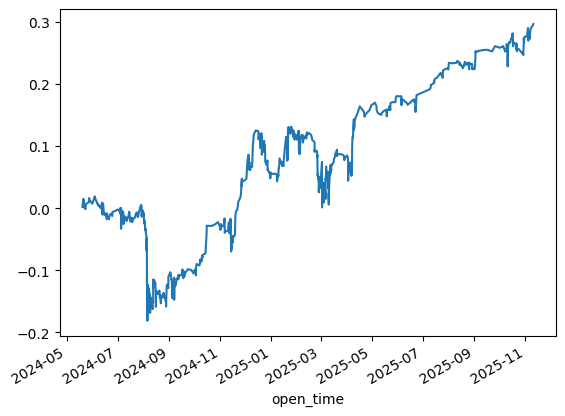

In [40]:
btcusdt_test[mask]['trade_log_return'].cumsum().plot()

### Trade Sizing

1. Static
2. Dynamic

### Static Sizing

In [41]:
#Always trade the same amount

In [42]:
size = 50.0
#Beginning of the trade - use this size
btcusdt_test['pre_trade_value'] = size
#convert back to a simple return
btcusdt_test['post_trade_value'] = np.exp(btcusdt_test['trade_log_return']) * size
btcusdt_test[['pre_trade_value','post_trade_value','trade_log_return']]

,pre_trade_value,post_trade_value,trade_log_return
open_time,,,
2024-05-17 01:00:00,50.0,49.872476,-0.002554
2024-05-17 02:00:00,50.0,50.031005,0.000620
2024-05-17 03:00:00,50.0,50.148199,0.002960
2024-05-17 04:00:00,50.0,49.906553,-0.001871
2024-05-17 05:00:00,50.0,50.192747,0.003848
...,...,...,...
2025-11-10 19:00:00,50.0,50.157157,0.003138
2025-11-10 20:00:00,50.0,49.910577,-0.001790
2025-11-10 21:00:00,50.0,49.823890,-0.003528


### Calculate Trade Gross PNL

In [43]:
#Round-trip gross PnL for that trade
btcusdt_test['trade_gross_pnl'] = btcusdt_test['post_trade_value'] - btcusdt_test['pre_trade_value']
btcusdt_test[['pre_trade_value','post_trade_value','trade_log_return','trade_gross_pnl']]

,pre_trade_value,post_trade_value,trade_log_return,trade_gross_pnl
open_time,,,,
2024-05-17 01:00:00,50.0,49.872476,-0.002554,-0.127524
2024-05-17 02:00:00,50.0,50.031005,0.000620,0.031005
2024-05-17 03:00:00,50.0,50.148199,0.002960,0.148199
2024-05-17 04:00:00,50.0,49.906553,-0.001871,-0.093447
2024-05-17 05:00:00,50.0,50.192747,0.003848,0.192747
...,...,...,...,...
2025-11-10 19:00:00,50.0,50.157157,0.003138,0.157157
2025-11-10 20:00:00,50.0,49.910577,-0.001790,-0.089423
2025-11-10 21:00:00,50.0,49.823890,-0.003528,-0.176110


<Axes: xlabel='open_time'>

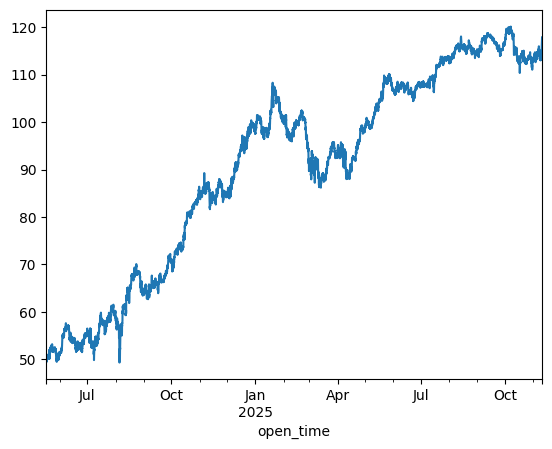

In [44]:
btcusdt_test['equity_curve_gross'] = size + btcusdt_test['trade_gross_pnl'].cumsum()
btcusdt_test['equity_curve_gross'].plot()

In [45]:
btcusdt_test['trade_gross_pnl'].mean()

np.float64(0.005204056963856418)

In [46]:
#how much we end with if we start with $50
size + btcusdt_test['trade_gross_pnl'].sum()

np.float64(117.81406629601298)

In [47]:
#that's the return
(size + btcusdt_test['trade_gross_pnl'].sum()) / size

np.float64(2.3562813259202597)

### Dynamic Trade Sizing

In [48]:
#Dynamic - biasing based on certain criteria
#Kelly Criterion
#Dynamic sizing should give us better sizing than static
#Does compund trade sizing improve those statistics?

Compounding Trade Sizing

In [49]:
#We just reinvest money we make - it helps log returns

In [50]:
btcusdt_test[['pre_trade_value','post_trade_value','trade_log_return','trade_gross_pnl']]

,pre_trade_value,post_trade_value,trade_log_return,trade_gross_pnl
open_time,,,,
2024-05-17 01:00:00,50.0,49.872476,-0.002554,-0.127524
2024-05-17 02:00:00,50.0,50.031005,0.000620,0.031005
2024-05-17 03:00:00,50.0,50.148199,0.002960,0.148199
2024-05-17 04:00:00,50.0,49.906553,-0.001871,-0.093447
2024-05-17 05:00:00,50.0,50.192747,0.003848,0.192747
...,...,...,...,...
2025-11-10 19:00:00,50.0,50.157157,0.003138,0.157157
2025-11-10 20:00:00,50.0,49.910577,-0.001790,-0.089423
2025-11-10 21:00:00,50.0,49.823890,-0.003528,-0.176110


### Add compound log return

In [51]:
#they model compounding because of time-additivity of log returns

In [52]:
btcusdt_test['cum_trade_log_return'] = btcusdt_test['trade_log_return'].cumsum()

In [53]:
btcusdt_test['post_trade_value'] = np.exp(btcusdt_test['cum_trade_log_return']) * size

In [54]:
#post_trade_value from the previous trade
btcusdt_test['pre_trade_value'] = btcusdt_test['post_trade_value'].shift()

In [55]:
btcusdt_test[['trade_log_return','cum_trade_log_return','pre_trade_value','post_trade_value']]

,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value
open_time,,,,
2024-05-17 01:00:00,-0.002554,-0.002554,NaN,49.872476
2024-05-17 02:00:00,0.000620,-0.001934,49.872476,49.903403
2024-05-17 03:00:00,0.002960,0.001026,49.903403,50.051315
2024-05-17 04:00:00,-0.001871,-0.000845,50.051315,49.957772
2024-05-17 05:00:00,0.003848,0.003003,49.957772,50.150356
...,...,...,...,...
2025-11-10 19:00:00,0.003138,1.195715,164.778084,165.296005
2025-11-10 20:00:00,-0.001790,1.193925,165.296005,165.000379
2025-11-10 21:00:00,-0.003528,1.190396,165.000379,164.419216


In [56]:
#fill it with initial capital size
btcusdt_test['pre_trade_value'].fillna(size, inplace=True)

/tmp/ipython-input-3638548120.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  btcusdt_test['pre_trade_value'].fillna(size, inplace=True)


In [57]:
#We're making money from our stat edge trade

In [58]:
btcusdt_test[['trade_log_return','cum_trade_log_return','pre_trade_value','post_trade_value']]

,trade_log_return,cum_trade_log_return,pre_trade_value,post_trade_value
open_time,,,,
2024-05-17 01:00:00,-0.002554,-0.002554,50.000000,49.872476
2024-05-17 02:00:00,0.000620,-0.001934,49.872476,49.903403
2024-05-17 03:00:00,0.002960,0.001026,49.903403,50.051315
2024-05-17 04:00:00,-0.001871,-0.000845,50.051315,49.957772
2024-05-17 05:00:00,0.003848,0.003003,49.957772,50.150356
...,...,...,...,...
2025-11-10 19:00:00,0.003138,1.195715,164.778084,165.296005
2025-11-10 20:00:00,-0.001790,1.193925,165.296005,165.000379
2025-11-10 21:00:00,-0.003528,1.190396,165.000379,164.419216


In [59]:
btcusdt_test['trade_gross_pnl'] = btcusdt_test['post_trade_value'] - btcusdt_test['pre_trade_value']

In [60]:
btcusdt_test['trade_gross_pnl'].mean()

np.float64(0.008835249979686936)

In [61]:
np.exp(btcusdt_test['trade_log_return'].sum())

np.float64(3.3026428497060145)

In [62]:
#the same edge but differently executed
np.exp(btcusdt_test['trade_log_return'].sum()) * size

np.float64(165.13214248530073)

<Axes: xlabel='open_time'>

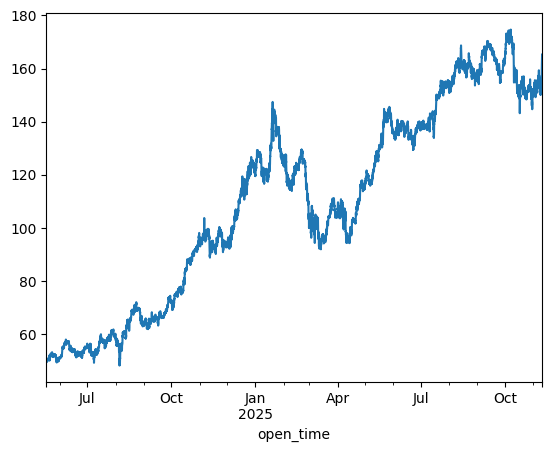

In [63]:
(np.exp(btcusdt_test['trade_log_return'].cumsum()) * 50).plot()

In [64]:
#The same equity curve just magnified
#It complements the time-based entry and exit
#It's all automated

### Adding Leverage

In [65]:
equity = 50.0
leverage = 2.0

In [66]:
trade_gross_pnl = 10.0
trade_gross_pnl * leverage

20.0

In [67]:
trade_gross_pnl = -20.0
trade_gross_pnl * leverage

-40.0

In [68]:
btcusdt_test['post_trade_value'] = np.exp(btcusdt_test['cum_trade_log_return']) * size * leverage

In [69]:
btcusdt_test['pre_trade_value'] = btcusdt_test['post_trade_value'].shift().fillna(size * leverage)

In [70]:
btcusdt_test['trade_gross_pnl'] = btcusdt_test['post_trade_value'] - btcusdt_test['pre_trade_value']

In [71]:
btcusdt_test[['pre_trade_value','post_trade_value','trade_gross_pnl']]

,pre_trade_value,post_trade_value,trade_gross_pnl
open_time,,,
2024-05-17 01:00:00,100.000000,99.744953,-0.255047
2024-05-17 02:00:00,99.744953,99.806805,0.061853
2024-05-17 03:00:00,99.806805,100.102630,0.295825
2024-05-17 04:00:00,100.102630,99.915544,-0.187086
2024-05-17 05:00:00,99.915544,100.300712,0.385168
...,...,...,...
2025-11-10 19:00:00,329.556168,330.592011,1.035843
2025-11-10 20:00:00,330.592011,330.000758,-0.591253
2025-11-10 21:00:00,330.000758,328.838432,-1.162327


<Axes: xlabel='open_time'>

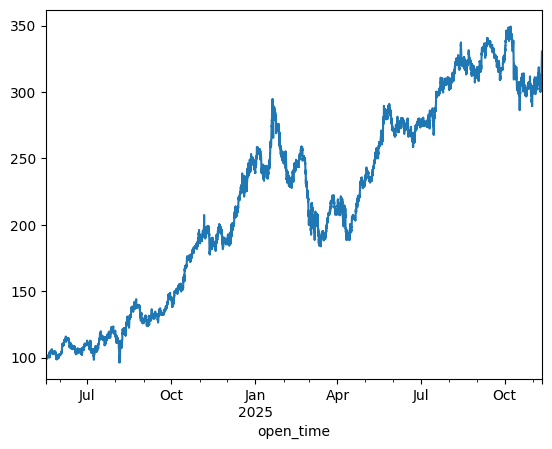

In [72]:
(np.exp(btcusdt_test['trade_log_return'].cumsum()) * 50 * leverage).plot()

In [73]:
(np.exp(btcusdt_test['trade_log_return'].sum()) * 50 * leverage) / size

np.float64(6.605285699412029)

In [74]:
#Tiny edge, hundreds of trades, no fees

### Conclusion

1. We evaluated the entry/exit signal
2. We evaluated the trade sizing
3. We evaluated the use of leverage

### Key Takeaway

Alpha = Statistical Edge * Execution

Alpha = Statistical Edge * Compounding * Leverage

In [75]:
#Once you have a model backtest the execution

### Exercises

### Exercise 1: Can we run this as a taking strat?

Add taker transaction fees to calculate net return and pnl. Remeber you need to calculate round-trip fees - opening and closing.



In [76]:
#Calc the net PnL
#Take trades, 1 hour based predictions
#Taker - market order - paying a higher fee

In [86]:
taker_fee = binance.TAKER_FEE
maker_fee = binance.MAKER_FEE

trades = btcusdt_test.assign(
    taker_fee=btcusdt_test['pre_trade_value'] * taker_fee + btcusdt_test['post_trade_value'] * taker_fee,
    maker_fee=btcusdt_test['pre_trade_value'] * maker_fee + btcusdt_test['post_trade_value'] * maker_fee
)


In [89]:
trades = trades.assign(
    trade_net_taker_pnl=trades['trade_gross_pnl'] - trades['taker_fee'],
    trade_net_maker_pnl=trades['trade_gross_pnl'] - trades['maker_fee']
)

In [91]:
trades.head()

,open,high,low,close,volume,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir,...,trade_log_return,pre_trade_value,post_trade_value,trade_gross_pnl,equity_curve_gross,cum_trade_log_return,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl
open_time,,,,,,,,,,,,,,,,,,,,,
2024-05-17 01:00:00,65477.9,65478.0,65061.2,65311.0,6160.987,-0.002554,0.003983,-0.002626,-0.000610,0,...,-0.002554,100.000000,99.744953,-0.255047,49.872476,-0.002554,0.089885,0.089885,-0.344933,-0.344933
2024-05-17 02:00:00,65311.1,65430.0,65146.5,65351.5,4190.566,0.000620,-0.002554,0.003983,-0.002626,1,...,0.000620,99.744953,99.806805,0.061853,49.903482,-0.001934,0.089798,0.089798,-0.027945,-0.027945
2024-05-17 03:00:00,65351.4,65850.0,65300.3,65545.2,11900.518,0.002960,0.000620,-0.002554,0.003983,1,...,0.002960,99.806805,100.102630,0.295825,50.051680,0.001026,0.089959,0.089959,0.205865,0.205865
2024-05-17 04:00:00,65545.1,65600.0,65327.7,65422.7,5906.313,-0.001871,0.002960,0.000620,-0.002554,0,...,-0.001871,100.102630,99.915544,-0.187086,49.958233,-0.000845,0.090008,0.090008,-0.277094,-0.277094
2024-05-17 05:00:00,65422.8,65675.0,65400.0,65674.9,4946.005,0.003848,-0.001871,0.002960,0.000620,1,...,0.003848,99.915544,100.300712,0.385168,50.150980,0.003003,0.090097,0.090097,0.295070,0.295070


### Exercise 2: Can we run this as a making strat?

In [77]:
#Evaluate the net PNL for making
#it assumes you get filled at this time

### Exercise 3: Re-sample the time series to find a good taking strat

In [78]:
#1-hour, 8-hour,1-day intervals